<a href="https://colab.research.google.com/github/dpcks/playdata/blob/main/DeepLearning/12_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전이학습
- 다른 Task 에서 대량의 데이터로 학습된 모델의 가중치를 활용하여 비슷한 다른 Task에 적용하여 모델 성능을 향상시키는 학습 방법


## 일반적으로 합성곱 신경망 기반 모델들은 두가지 파트로 구성
- Feature extractor 
    - 합성곱층과 풀링층으로 구성
- Classifier
    - 주로 Fully-connected 레이어로 구성


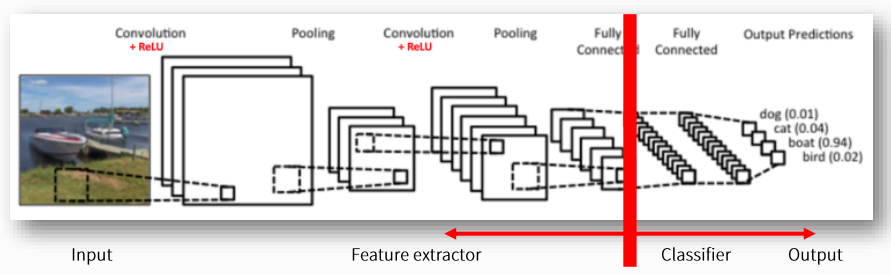

## 합성곱 신경망 학습에 특징
- input 에 가까운 부분은 일반적인 특징을 추출하도록 학습된다.
- output 에 가까워 질수록 특정 문제 혹은 데이터셋에서만 나타나는 구체적인 특징을 추출하도록 학습된다.


## 미세 조정(Fine-tuning)
- 기존 모델의 분류기를 제거하고, 풀고자 하는 문제에 맞는 새로운 분류기를 추가하여 학습
- 1번째는 lr을 작게줘야함, 두번째는 반쪽(파랑)만 가중치 업데이트하자, 마지막은 동결 

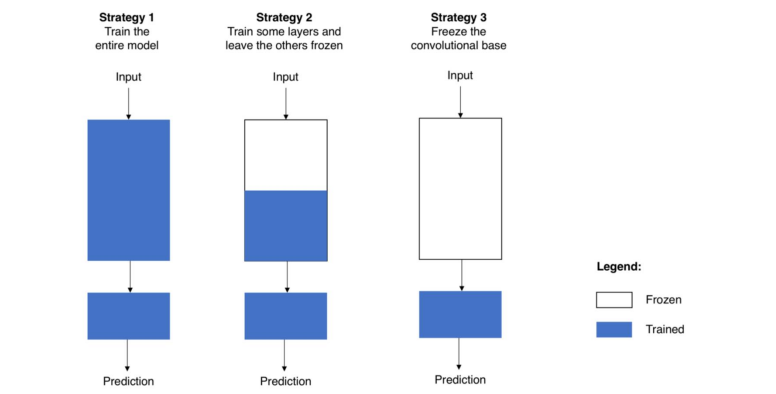

# 데이터 경로를 변경하시오

In [ ]:
DATA_PATH = "/content/drive/MyDrive/딥러닝/data/"
SEED = 42

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random # 시드 고정을 위해
import os # 시드 고정을 위해
from PIL import Image

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )



device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 복사및 압축풀기

In [ ]:
if not os.path.isdir("train"):
    !cp "{DATA_PATH}cats_and_dogs.zip" "cats_and_dogs.zip"
    !unzip -qq "cats_and_dogs.zip"  

# 이미지 파일 경로 리스트에 담기

In [ ]:
from glob import glob
cats_list = sorted(glob("train/cats/*.jpg"),key= lambda x : x)  
dogs_list = sorted(glob("train/dogs/*.jpg"),key= lambda x : x)
len(cats_list) , len(dogs_list) , cats_list[:5]

(1000,
 1000,
 ['train/cats/cat.0.jpg',
  'train/cats/cat.1.jpg',
  'train/cats/cat.10.jpg',
  'train/cats/cat.100.jpg',
  'train/cats/cat.101.jpg'])

# 학습 이미지경로 및 정답데이터 생성

In [ ]:
img_path = cats_list + dogs_list 
labels = [0] * len(cats_list) + [1] * len(dogs_list)

len(img_path) , len(labels) , img_path[:5]

(2000,
 2000,
 ['train/cats/cat.0.jpg',
  'train/cats/cat.1.jpg',
  'train/cats/cat.10.jpg',
  'train/cats/cat.100.jpg',
  'train/cats/cat.101.jpg'])

# 섞기

In [ ]:
train = np.array(img_path,dtype="object")
target = np.array(labels)

np.random.seed(SEED) 
index_list = np.arange(train.shape[0]) 
np.random.shuffle(index_list) 
np.random.shuffle(index_list) 

train = train[index_list] 
target = target[index_list].reshape(-1,1) 

target[:10] , target.shape

(array([[1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1]]), (2000, 1))

- 다음의 url 접속하여 사전학습 모델을 선택하면 된다.
    - https://pytorch.org/vision/stable/models.html#classification

- Acc@1 탑원 우리가 일반적으로 알고있는 정확도
- ACC@5 탑파이브 가장높은 다섯개의 확률(클래스)
- resnet50 모델
- 민맥스 스케일링후 정규화
    - mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] 224 * 224(crop_size)

In [ ]:
from torchvision.models import resnet50 , ResNet50_Weights 

In [ ]:
ResNet50_Weights.DEFAULT 

ResNet50_Weights.IMAGENET1K_V2

In [ ]:
batch

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2) # DEFAULT 로 넣으면 가중치를 자동으로 지정
model 

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 모델

In [ ]:
class Net(torch.nn.Module):
    def __init__(self): 
        super().__init__()
        self.pre_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.pre_model.fc = torch.nn.Linear(2048,1) # 인스턴스 변수활용

    def forward(self, x):
        x  = self.pre_model(x)
        return x

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchinfo
model = Net()
torchinfo.summary(model,(32,3,224,224))  # B,C ,H,W # 채널이 3인 이유는 컬러

Layer (type:depth-idx)                        Output Shape              Param #
Net                                           [32, 1]                   --
├─ResNet: 1-1                                 [32, 1]                   --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         75,008
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         70,400
│    │    └─Bottleneck: 3-3                   [32, 256, 56, 56]         70,400
│    └─Sequential: 2-6                        [32, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [32, 512, 28, 28]         379,392

# transforms 객체 생성

In [ ]:
from torchvision import transforms

img_size = [224,224] # crop size 224

train_lst = [
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p=0.4),# 증강 추가할수있음
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 홈페이지에 나와있음 정규화
    ]
train_transform = transforms.Compose(train_lst)

test_lst = [
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
test_transform = transforms.Compose(test_lst)

# 데이터셋

In [ ]:
class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self ,transform , x, y = None ): 
        self.x = x
        self.y = y
        self.transform = transform
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, idx): 
        item = {}
        x = Image.open(self.x[idx])
        item["x"] = self.transform(x)
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])
        return item   

In [ ]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0 
    model.train() 
    for batch in dataloader: 
        pred = model(batch["x"].to(device)) 
        loss = loss_fn(pred, batch["y"].to(device)) 
        
        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step() 
        
        epoch_loss += loss.item()

    epoch_loss /= len(dataloader) 

    return epoch_loss 

In [ ]:
@torch.no_grad() 
def test_loop(dataloader,model,loss_fn,device): 
    epoch_loss = 0
    model.eval() 

    pred_list = []
    sig = torch.nn.Sigmoid()

    for batch in dataloader:
        
        pred = model(batch["x"].to(device))
        if batch.get("y") is not None: 
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()
        
        pred = sig(pred)
        pred = pred.to("cpu").numpy() 
        pred_list.append(pred)

    epoch_loss /= len(dataloader)

    pred = np.concatenate(pred_list) 
    return epoch_loss , pred 

In [ ]:
n_splits = 5
batch_size = 32 
epochs = 100
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

# 학습

In [ ]:
is_holdout = True
reset_seeds(SEED)
best_score_list = []
for i,(tri,vai) in enumerate(cv.split(train)):
    
    model = Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001) # LR 낮추면 다잘나올수있음
    
    train_dt = CatDogDataset(train_transform,train[tri],target[tri])
    valid_dt = CatDogDataset(test_transform,train[vai],target[vai])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size,shuffle=False)

    best_score = 0
    patience = 0

    for epoch in tqdm(range(epochs)):
        
        train_loss = train_loop(train_dl, model, loss_fn,optimizer,device )
        valid_loss , pred = test_loop(valid_dl, model, loss_fn,device  )
        pred = (pred > 0.5).astype(int) 
        
        score = accuracy_score(target[vai],pred )
        print(train_loss,valid_loss,score)
        patience += 1
        if best_score < score:
            patience = 0
            best_score = score
            torch.save(model.state_dict(),f"model_{i}.pth")

        if patience == 5:
            break
    print(f"Fold ({i}), BEST ACC: {best_score}")
    best_score_list.append(best_score)

    if is_holdout:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

0.2383128732815385 0.032523152275154225 0.99
0.04246187217533588 0.02300109090999915 0.9975
0.022497958689928054 0.0237455007333595 0.995
0.005802924311719835 0.011574194569570513 0.995
0.002608862897614017 0.009667490752270589 0.9975
0.0046075264282990245 0.017002508097973008 0.995
0.0018895258102566003 0.014796683417024234 0.9975
Fold (0), BEST ACC: 0.9975


# 동결(Freezing)

## 특성 부분 전체 동결

In [ ]:
class FreezNet(torch.nn.Module):
    def __init__(self): 
        super().__init__()
        self.pre_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        for param in self.pre_model.parameters(): 
            param.requires_grad = False 
        self.pre_model.fc = torch.nn.Linear(2048,1) # 가중치 업데이트

    def forward(self, x):
        x  = self.pre_model(x)
        return x

In [ ]:
model = FreezNet()
for name, param in model.named_parameters(): 
    print(name ,param.requires_grad) 

## 일부 동결

In [ ]:
model = Net()
model 

Net(
  (pre_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [ ]:
model = Net()
for name, param in model.named_parameters(): 
    if name.startswith("pre_model.layer3"):
        break #LAYER 2까지만
    param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    print(name ,param.requires_grad) 

pre_model.conv1.weight False
pre_model.bn1.weight False
pre_model.bn1.bias False
pre_model.layer1.0.conv1.weight False
pre_model.layer1.0.bn1.weight False
pre_model.layer1.0.bn1.bias False
pre_model.layer1.0.conv2.weight False
pre_model.layer1.0.bn2.weight False
pre_model.layer1.0.bn2.bias False
pre_model.layer1.0.conv3.weight False
pre_model.layer1.0.bn3.weight False
pre_model.layer1.0.bn3.bias False
pre_model.layer1.0.downsample.0.weight False
pre_model.layer1.0.downsample.1.weight False
pre_model.layer1.0.downsample.1.bias False
pre_model.layer1.1.conv1.weight False
pre_model.layer1.1.bn1.weight False
pre_model.layer1.1.bn1.bias False
pre_model.layer1.1.conv2.weight False
pre_model.layer1.1.bn2.weight False
pre_model.layer1.1.bn2.bias False
pre_model.layer1.1.conv3.weight False
pre_model.layer1.1.bn3.weight False
pre_model.layer1.1.bn3.bias False
pre_model.layer1.2.conv1.weight False
pre_model.layer1.2.bn1.weight False
pre_model.layer1.2.bn1.bias False
pre_model.layer1.2.conv2.weigh